In [1]:
# Cell 1: Download and preprocess CIFAR-10 and PCam datasets for ResNet34 (224x224)

import torch, gc
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from torchvision.utils import draw_bounding_boxes
# from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GradCAMPlusPlus as GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from captum.attr import IntegratedGradients, GradientShap , LayerGradCam  
import torch.nn.functional as F
import torch.nn as nn

import os, random
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from sklearn.metrics import pairwise_distances, accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
# from skimage.metrics import structural_similarity as ssim
import torchvision.transforms.functional as TF

import pickle
import pandas as pd
from collections import Counter
from PIL import Image
import quantus
from quantus.metrics.complexity import Sparseness
from quantus.metrics.faithfulness import PixelFlipping
from quantus.metrics.robustness import Consistency
from pathlib import Path

from functools import partial
import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#For reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
torch.set_num_threads(4)  # 4 threads per worker
torch.multiprocessing.set_sharing_strategy('file_system')


Using device: cuda


In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"

# Loop through all available GPUs
for gpu_id in range(torch.cuda.device_count()):
    torch.cuda.set_device(gpu_id)  # Set the current GPU
    torch.cuda.empty_cache()  
    torch.cuda.ipc_collect()
     # Clear the cache for this GPU
    gc.collect()                   # Trigger garbage collection

print("All GPU memory has been cleared.")


All GPU memory has been cleared.


Load the dataset with transformations

In [3]:
# ImageNet normalization stats for ResNet34 pretrained weights [6][9]

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


# Cifar transform: resize to 224x224, convert to tensor, normalize
cifar_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

cifar_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# PCam transform: resize to 224x224, convert to tensor, normalize
pcam_train_transform = transforms.Compose([
    # Apply augmentations on the original 96x96 images FIRST
    transforms.RandomResizedCrop(
        size=96,  # Operate on the native PCam resolution (96x96)
        scale=(0.8, 1.0),  # Randomly crop 80-100% of the original area
        interpolation=transforms.InterpolationMode.BICUBIC  # Smoother scaling
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    # Resize to 224x224 AFTER augmentations (minimizes upscaling artifacts)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC  # Higher quality
    ),
    # Conservative color augmentations (medical images are sensitive to color shifts)
    transforms.ColorJitter(
        brightness=0.1,  # Keep subtle for H&E-stained tissue
        contrast=0.1,
        saturation=0.0,   # Avoid altering saturation (critical for PCam)
        hue=0.0
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# PCam transform: resize to 224x224, convert to tensor, normalize
pcam_test_transform = transforms.Compose([
    # Resize to 224x224 (minimizes upscaling artifacts)
    transforms.Resize(
        (224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC  # Higher quality
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


# CIFAR-10 download and preprocessing
cifar10_train = datasets.CIFAR10(
    root='./data',
    train=True,
    download=False,
    transform=cifar_train_transform
)
cifar10_test = datasets.CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=cifar_test_transform
)

# PCam download and preprocessing [1][2][7]
pcam_train = datasets.PCAM(
    root='./data',
    split='train',
    download=False,
    transform=pcam_train_transform
)
pcam_val = datasets.PCAM(
    root='./data',
    split='val',
    download=False,
    transform=pcam_test_transform
)
pcam_test = datasets.PCAM(
    root='./data',
    split='test',
    download=False,
    transform=pcam_test_transform
)

# Example DataLoader setup (adjust batch_size as needed)
# cifar10_train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True,persistent_workers=True)
# cifar10_test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,persistent_workers=True)

# pcam_train_loader = DataLoader(pcam_train, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True,persistent_workers=True)
# pcam_val_loader = DataLoader(pcam_val, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True,persistent_workers=True)
# pcam_test_loader = DataLoader(pcam_test, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, persistent_workers=True)

# print("CIFAR-10 and PCam datasets are downloaded and preprocessed to 224x224 for ResNet34.")


Make the balanced dataset indices

In [4]:
def stratified_subset(dataset, n_samples, seed=42):
    # Extract labels from the dataset
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=seed)
    idx, _ = next(sss.split(np.zeros(len(labels)), labels))
    return Subset(dataset, idx), idx

def stratified_train_val_split(dataset, train_size, val_size, seed=42):
    labels = np.array(dataset.targets)
    all_indices = np.arange(len(labels))
    
    train_idx, val_idx = train_test_split(
        all_indices,
        train_size=train_size,
        test_size=val_size,
        stratify=labels,
        random_state=seed
    )
    
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)
    return train_subset, val_subset, train_idx, val_idx

# # Usage example:
# cifar_train_balanced, cifar_val_balanced, cifar_train_idx, cifar_val_idx = stratified_train_val_split(cifar10_train, 40000, 10000)
cifar_tracking, cifar_tracking_idx = stratified_subset(cifar_val_subset, 100)

# # # Example for PCam (assuming you have pcam_train, pcam_val, pcam_test)
# pcam_train_balanced, train_idx = stratified_subset(pcam_train, 40000)
# pcam_val_balanced, val_idx = stratified_subset(pcam_val, 10000)
# pcam_test_balanced, test_idx = stratified_subset(pcam_test, 10000)
pcam_tracking, pcam_tracking_idx = stratified_subset(pcam_val_subset, 100)



NameError: name 'cifar_val_subset' is not defined

In [ ]:
# For PCam train
pcam_train_labels = [pcam_train_balanced[i][1] for i in range(len(pcam_train_balanced))]
train_counts = Counter(pcam_train_labels)
print("PCam Train class counts:", train_counts)

# For PCam val
pcam_val_labels = [pcam_val_balanced[i][1] for i in range(len(pcam_val_balanced))]
val_counts = Counter(pcam_val_labels)
print("PCam Val class counts:", val_counts)

# For PCam test
pcam_test_labels = [pcam_test_balanced[i][1] for i in range(len(pcam_test_balanced))]
test_counts = Counter(pcam_test_labels)
print("PCam Test class counts:", test_counts)

# For CIFAR-10 train
cifar_train_labels = [cifar_train_balanced[i][1] for i in range(len(cifar_train_balanced))]
train_counts_cifar = Counter(cifar_train_labels)
print("CIFAR-10 Train class counts:", train_counts_cifar)

# For CIFAR-10 val
cifar_val_labels = [cifar_val_balanced[i][1] for i in range(len(cifar_val_balanced))]
val_counts_cifar = Counter(cifar_val_labels)
print("CIFAR-10 Val class counts:", val_counts_cifar)


PCam Train class counts: Counter({1: 20000, 0: 20000})
PCam Val class counts: Counter({0: 5005, 1: 4995})
PCam Test class counts: Counter({0: 5002, 1: 4998})
CIFAR-10 Train class counts: Counter({6: 4000, 7: 4000, 8: 4000, 3: 4000, 2: 4000, 1: 4000, 4: 4000, 9: 4000, 0: 4000, 5: 4000})
CIFAR-10 Val class counts: Counter({2: 1000, 7: 1000, 1: 1000, 9: 1000, 6: 1000, 8: 1000, 0: 1000, 3: 1000, 5: 1000, 4: 1000})


In [6]:
# For PCam tracking
pcam_tracking_labels = [pcam_tracking[i][1] for i in range(len(pcam_tracking))]
tracking_counts = Counter(pcam_tracking_labels)
print("PCam Tracking class counts:", tracking_counts)

# For CIFAR-10 tracking
cifar_tracking_labels = [cifar_tracking[i][1] for i in range(len(cifar_tracking))]
tracking_counts_cifar = Counter(cifar_tracking_labels)
print("CIFAR-10 Tracking class counts:", tracking_counts_cifar)

PCam Tracking class counts: Counter({0: 50, 1: 50})
CIFAR-10 Tracking class counts: Counter({8: 10, 4: 10, 0: 10, 6: 10, 5: 10, 3: 10, 2: 10, 1: 10, 9: 10, 7: 10})


In [7]:

# Save the balanced splits
# Create directories if they don't exist
os.makedirs('./data/balanced_splits', exist_ok=True)
# with open('./data/balanced_splits/pcam_train_idx.pkl', 'wb') as f:
#     pickle.dump(train_idx, f)
# with open('./data/balanced_splits/pcam_val_idx.pkl', 'wb') as f:
#     pickle.dump(val_idx, f)
# with open('./data/balanced_splits/pcam_test_idx.pkl', 'wb') as f:
#     pickle.dump(test_idx, f)
with open('./data/balanced_splits/pcam_tracking_idx.pkl', 'wb') as f:
    pickle.dump(pcam_tracking_idx, f)
# with open('./data/balanced_splits/cifar_train_idx.pkl', 'wb') as f:
#     pickle.dump(cifar_train_idx, f)
# with open('./data/balanced_splits/cifar_val_idx.pkl', 'wb') as f:
#     pickle.dump(cifar_val_idx, f)
with open('./data/balanced_splits/cifar_tracking_idx.pkl', 'wb') as f:
    pickle.dump(cifar_tracking_idx, f)
# For CIFAR-10 test set (use all indices, as you don't subset)
# cifar_test_idx = np.arange(len(cifar10_test))

# with open('./data/balanced_splits/cifar_test_idx.pkl', 'wb') as f:
#     pickle.dump(cifar_test_idx, f)


Make the subsets from saved indices

In [4]:
batch_size = 1024
workers = 30
print(f"Number of workers: {workers}")
# Load the balanced splits
# PCam
with open('./data/balanced_splits/pcam_train_idx.pkl', 'rb') as f:
    train_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_val_idx.pkl', 'rb') as f:
    val_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_test_idx.pkl', 'rb') as f:
    test_idx = pickle.load(f)
with open('./data/balanced_splits/pcam_tracking_idx.pkl', 'rb') as f:
    pcam_tracking_idx = pickle.load(f)

# CIFAR-10
with open('./data/balanced_splits/cifar_train_idx.pkl', 'rb') as f:
    cifar_train_idx = pickle.load(f)
with open('./data/balanced_splits/cifar_val_idx.pkl', 'rb') as f:
    cifar_val_idx = pickle.load(f)
with open('./data/balanced_splits/cifar_test_idx.pkl', 'rb') as f:
    cifar_test_idx = pickle.load(f)
with open('./data/balanced_splits/cifar_tracking_idx.pkl', 'rb') as f:
    cifar_tracking_idx = pickle.load(f)

def create_random_subset(dataset, subset_length, seed=42):
    """
    Quickly creates a random subset of the dataset.
    """
    np.random.seed(seed)
    indices = np.random.choice(len(dataset), subset_length, replace=False)
    return Subset(dataset, indices)

# # Create training and test subsets
# pcam_train_subset = create_random_subset(pcam_train, 3000)
# pcam_test_subset = create_random_subset(pcam_test, 800)
# pcam_val_subset = create_random_subset(pcam_val, 800)
# cifar_train = create_random_subset(cifar10_train, 40000)
# cifar_val = create_random_subset(cifar10_train, 10000)




cifar_train_subset = Subset(cifar10_train, cifar_train_idx)
cifar_val_subset = Subset(cifar10_train, cifar_val_idx)
cifar_test_subset = Subset(cifar10_test, cifar_test_idx)
cifar_tracking_subset = Subset(cifar_val_subset, cifar_tracking_idx)

pcam_train_subset = Subset(pcam_train, train_idx)
pcam_val_subset = Subset(pcam_val, val_idx)
pcam_test_subset = Subset(pcam_test, test_idx)
pcam_tracking_subset = Subset(pcam_val_subset, pcam_tracking_idx)
pcam_train_subset = create_random_subset(pcam_train_subset, 5000)
pcam_test_subset = create_random_subset(pcam_test_subset, 1000)
pcam_val_subset = create_random_subset(pcam_val_subset, 1000)

# Get the original index for a sample in pcam_tracking_subset
# original_index = pcam_val_subset.indices[pcam_tracking_idx[i]]
# If pcam_val itself is a Subset, you may need to go one level deeper:
# original_index = pcam_val.indices[pcam_val_subset.indices[pcam_tracking_idx[i]]]


# Create DataLoaders
pcam_train_loader = DataLoader(
    pcam_train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

pcam_test_loader = DataLoader(
    pcam_test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

pcam_val_loader = DataLoader(
    pcam_val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_train_loader = DataLoader(
    cifar_train_subset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_val_loader = DataLoader(
    cifar_val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

cifar_test_loader = DataLoader(
    cifar_test_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
    persistent_workers=True
)

print(f"Pcam Train subset size: {len(pcam_train_subset)}")
print(f"Pcam Test subset size: {len(pcam_test_subset)}")
print(f"Pcam Validation subset size: {len(pcam_val_subset)}")
print(f"Pcam Tracking subset size: {len(pcam_tracking_subset)}")
print(f"CIFAR-10 Train subset size: {len(cifar_train_subset)}")
print(f"CIFAR-10 Validation subset size: {len(cifar_val_subset)}")
print(f"CIFAR-10 Test subset size: {len(cifar_test_subset)}")
print(f"CIFAR-10 Tracking subset size: {len(cifar_tracking_subset)}")


Number of workers: 30
Pcam Train subset size: 5000
Pcam Test subset size: 1000
Pcam Validation subset size: 1000
Pcam Tracking subset size: 100
CIFAR-10 Train subset size: 40000
CIFAR-10 Validation subset size: 10000
CIFAR-10 Test subset size: 10000
CIFAR-10 Tracking subset size: 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


Original index of the first sample in pcam_tracking_subset: 28662


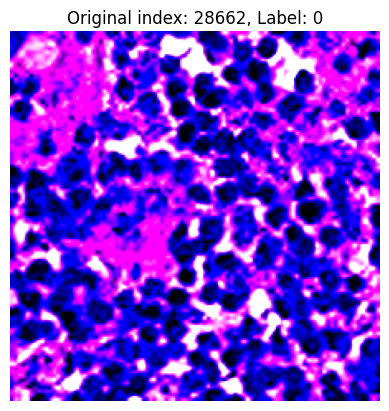

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


Tracking index of the first sample in pcam_tracking_subset: 5152


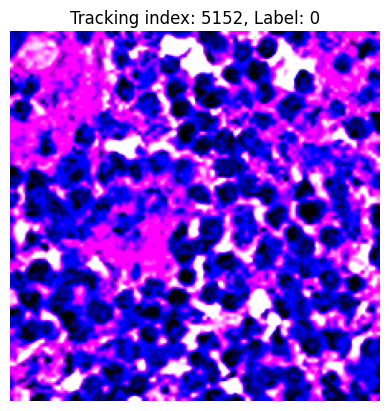

In [5]:
x = 5
# original_indices = [pcam_val_subset.indices[i] for i in pcam_tracking_idx]

original_index = pcam_val_subset.indices[pcam_tracking_idx[x]]
print(f"Original index of the first sample in pcam_tracking_subset: {original_index}")
image, label = pcam_val[original_index]
# Convert tensor to numpy and plot (if using torch)
image_np = image.permute(1, 2, 0).numpy()
plt.imshow(image_np)
plt.title(f"Original index: {original_index}, Label: {label}")
plt.axis('off')
plt.show()

image, label = pcam_tracking_subset[x]
tracking_index = pcam_tracking_idx[x]
print(f"Tracking index of the first sample in pcam_tracking_subset: {tracking_index}")
# Convert tensor to numpy and plot (if using torch)
image_np = image.permute(1, 2, 0).numpy()
plt.imshow(image_np)
plt.title(f"Tracking index: {tracking_index}, Label: {label}")
plt.axis('off')
plt.show()


In [ ]:
# Helper function to denormalize and show an image
def imshow(img, mean=IMAGENET_MEAN, std=IMAGENET_STD, title=None):
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Function to show first 3 images from a DataLoader
def show_first_n_images(dataloader, class_names, dataset_name, n=3):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    plt.figure(figsize=(n * 3, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        imshow(images[i])
        if class_names is not None:
            plt.title(f"{dataset_name}: {class_names[labels[i]]}")
        else:
            plt.title(f"{dataset_name}: Label {labels[i].item()}")
    plt.suptitle(f"First {n} images from {dataset_name}")
    plt.show()

# Class names for CIFAR-10 and PCam
cifar10_classes = cifar10_train.classes
pcam_classes = ['Negative', 'Positive']

# Show images from each DataLoader
show_first_n_images(cifar10_train_loader, cifar10_classes, "CIFAR-10 Train")
show_first_n_images(cifar10_test_loader, cifar10_classes, "CIFAR-10 Test")
show_first_n_images(pcam_train_loader, pcam_classes, "PCam Train")
show_first_n_images(pcam_val_loader, pcam_classes, "PCam Val")
show_first_n_images(pcam_test_loader, pcam_classes, "PCam Test")


Initializing CNN for both the datasets

In [5]:
# Initialize ResNet34 model for CIFAR-10 and PCam
def initialize_resnet34(num_classes, device=None):
    """
    Initializes a ResNet34 model with a specified number of output classes.

    Args:
        num_classes (int): Number of output classes for the classification task.
        device (torch.device, optional): The device to load the model onto. Defaults to CUDA if available.

    Returns:
        torch.nn.Module: The initialized ResNet34 model.
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    print(f"Initialized ResNet34 for {num_classes} classes on {device} (DataParallel={torch.cuda.device_count() > 1})")
    return model.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize models for CIFAR-10 and PCam
# cifar_model = initialize_resnet34(num_classes=10, device=device)
pcam_model = initialize_resnet34(num_classes=2, device=device)


Initialized ResNet34 for 2 classes on cuda:0 (DataParallel=True)


<h1>This is for XAI AL but for specific cases</h1>

CNN Training Code

In [ ]:

# ================== TORCH WRAPPER WITH EARLY STOPPING ==================
class TorchWrapper:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
        self.best_weights = None
        
    def fit(self, train_loader, val_loader=None, epochs=5, patience=3, dataset_name='cifar10'):
        self.model.train()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
        criterion = torch.nn.CrossEntropyLoss()
        best_val_loss = float('inf')
        best_val_recall = 0.0
        patience_counter = 0

        for epoch in range(epochs):
            # Training
            train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validation and early stopping
            if dataset_name == 'cifar10':
                if val_loader:
                    val_loss = 0.0
                    self.model.eval()
                    with torch.no_grad():
                        for val_images, val_labels in val_loader:
                            val_images = val_images.to(self.device)
                            val_labels = val_labels.to(self.device)
                            outputs = self.model(val_images)
                            val_loss += criterion(outputs, val_labels).item()
                    
                    avg_val_loss = val_loss / len(val_loader)
                    scheduler.step(avg_val_loss)  # Update learning rate based on validation loss
                    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f}")
                    
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        self.best_weights = copy.deepcopy(self.model.state_dict())
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= patience:
                            print("Early stopping triggered!")
                            self.model.load_state_dict(self.best_weights)
                            torch.cuda.empty_cache()
                            # torch.save(self.model.state_dict(), 'best_model.pth')
                            break
            elif dataset_name == 'pcam':
                    if val_loader:
                        val_loss = 0.0
                        all_preds = []
                        all_labels = []
                        self.model.eval()
                        with torch.no_grad():
                            for val_images, val_labels in val_loader:
                                val_images = val_images.to(self.device)
                                val_labels = val_labels.to(self.device)
                                outputs = self.model(val_images)
                                val_loss += criterion(outputs, val_labels).item()

                                # Collect predictions and labels for recall calculation
                                preds = torch.argmax(outputs, dim=1)
                                all_preds.extend(preds.cpu().numpy())
                                all_labels.extend(val_labels.cpu().numpy())
                                
                        avg_val_loss = val_loss / len(val_loader)
                        val_recall = recall_score(all_labels, all_preds, average='binary')
                        scheduler.step(avg_val_loss)  # Update learning rate based on recall

                        print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f} | Val Recall: {val_recall:.4f}")
                        
                        if avg_val_loss < best_val_loss:  # Early stopping based on recall
                            best_val_recall = val_recall
                            best_val_loss = avg_val_loss
                            self.best_weights = copy.deepcopy(self.model.state_dict())
                            patience_counter = 0
                        else:
                            patience_counter += 1
                            if patience_counter >= patience:
                                print("Early stopping triggered!")
                                self.model.load_state_dict(self.best_weights)
                                torch.cuda.empty_cache()
                                # torch.save(self.model.state_dict(), 'best_model.pth')
                                break
            else:
                raise ValueError("Unsupported dataset name. Use 'cifar10' or 'pcam'.")


            torch.cuda.empty_cache()

    def predict_proba(self, data_loader):
        self.model.eval()
        probs = []
        with torch.no_grad():
            for images, _ in data_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                probs.append(torch.softmax(outputs, dim=1).cpu())
        return torch.cat(probs).numpy()

XAI Visaulization Functions

In [7]:
# ================== TRACKING DATASET LOADER ==================
def get_xai_loader(tracking_subset, n_samples=100):
    # Use only the first n_samples for testing
    indices = list(range(min(n_samples, len(tracking_subset))))
    test_subset = Subset(tracking_subset, indices)
    loader = DataLoader(test_subset, batch_size=len(indices), shuffle=False)
    images, labels = next(iter(loader))
    return images, labels, indices

# ================== VISUALIZATION UTILITIES ==================
def overlay_center_box(img, mean, std, box_size=75, color="lime", width=1):
    """
    img: torch tensor [C, H, W], normalized
    mean, std: lists or arrays of length 3 (for unnormalization)
    """
    # Unnormalize
    img_disp = img.clone()
    for c in range(3):
        img_disp[c] = img_disp[c] * std[c] + mean[c]
    img_disp = (img_disp * 255).clamp(0,255).to(torch.uint8)

    # Box coordinates for 96x96 image
    H, W = img_disp.shape[1:]
    xmin = (W - box_size) // 2
    ymin = (H - box_size) // 2
    xmax = xmin + box_size
    ymax = ymin + box_size
    boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.int)

    # Draw box
    boxed_img = draw_bounding_boxes(img_disp, boxes, colors=color, width=width)
    return boxed_img.permute(1,2,0).cpu().numpy() / 255.0  # For plt.imshow

# ================== RESIZE FOR VISUALIZATION ==================
def resize_for_visualization(img_tensor, size=None):
    """
    img_tensor: torch.Tensor of shape [C, H, W]
    size: tuple (height, width)
    Returns resized tensor of shape [C, size[0], size[1]]
    """
    # Add batch dimension
    img_batch = img_tensor.unsqueeze(0)  # [1, C, H, W]

    # Resize using bilinear interpolation (good quality for images)
    resized_batch = F.interpolate(img_batch, size=size, mode='bilinear', align_corners=False)

    # Remove batch dimension
    resized_img = resized_batch.squeeze(0)  # [C, size[0], size[1]]

    return resized_img

# ================== UNNORMALIZE FUNCTION ==================
def unnormalize(img, mean, std):
    # Handle PyTorch tensors without converting to numpy
    if isinstance(img, torch.Tensor):
        img = img.clone()
        for c in range(img.shape[0]):
            img[c] = img[c] * std[c] + mean[c]
        return img  # Keep as tensor
    # Handle numpy arrays
    else:
        if img.ndim == 2:
            img = np.expand_dims(img, axis=0)
        img = img.transpose(1, 2, 0)
        img = img * std + mean
        return np.clip(img, 0, 1)


def normalize(img, mean, std):
    # img: [H, W, C] numpy array, values in [0, 1]
    img = (img - mean) / std
    img = img.transpose(2, 0, 1)  # [C, H, W]
    return img

def normalize_cifar(img,mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Normalize CIFAR-10 image in [C, H, W] format."""
    # Reshape mean/std to [3, 1, 1] for channel-wise operations
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return (img - mean) / std

def unnormalize_cifar(img, mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Unnormalize CIFAR-10 image in [C, H, W] format."""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return np.clip(img * std + mean, 0, 1)


# ================== XAI VISUALIZATION ==================
def show_xai(images, labels, model, gradshap, gradcam, device, idxs, mean, std, dataset_name = None,
             class_names=[], baseline_loader=None, n_baselines=10, overlay_box=False, baseline_imgs=None, cycle=0):
    
    save_dir = f"data/xai_images/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)

    # Handle DataParallel models
    if isinstance(model, torch.nn.DataParallel):
        model_for_gc = model.module
    else:
        model_for_gc = model
        
    model.eval()
    images = images.to(device)
    labels = labels.to(device)

    # Get baselines
    if baseline_imgs is not None:
        baseline_imgs = baseline_imgs
    elif baseline_loader is not None:
        baseline_imgs = []
        for b_images, _ in baseline_loader:
            baseline_imgs.append(b_images.to(device))
            if len(baseline_imgs) >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs)[:n_baselines]
    else:
        baseline_imgs = torch.randn(n_baselines, *images.shape[1:], device=device)

    # Compute explanations
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
    
    # GradientShap
    attr_gs = gradshap.attribute(images, baselines=baseline_imgs, target=labels).cpu().numpy()
    
    # GradCAM++
    gradcam_output = gradcam(input_tensor=images,
                            targets=[ClassifierOutputTarget(l.item()) for l in labels],
                            aug_smooth=True)
    
    # Visualization
    for i in range(images.shape[0]):
        img = images[i].cpu()
        if dataset_name == "pcam":
        # Resize to 96x96 for visualization
            res_img = resize_for_visualization(img, size=(96, 96))
        else:
            res_img = resize_for_visualization(img, size=(32, 32))
        
        if overlay_box:
            img_disp = overlay_center_box(img, mean, std)      
        else:
            img_disp = unnormalize_cifar(img, mean, std)    
            img_disp = np.transpose(img_disp, (1, 2, 0))  # shape: (H, W, 3)



        fig = plt.figure(figsize=(12, 3))
        
        # Original image
        plt.subplot(1,3,1)
        plt.imshow(img_disp)
        plt.title(f"ID {idxs[i]}\nTrue: {class_names[labels[i].item()]}\nPred: {class_names[preds[i]]}")
        plt.axis('off')

        # GradientShap
        plt.subplot(1,3,2)
        gs_map = np.abs(attr_gs[i]).sum(0)
        gs_map = (gs_map - gs_map.min()) / (gs_map.max() - gs_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gs_map, cmap='hot', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradientSHAP \n (higher = more important)")
        plt.axis('off')

        # GradCAM++
        plt.subplot(1,3,3)
        gc_map = gradcam_output[i]
        gc_map = (gc_map - gc_map.min()) / (gc_map.max() - gc_map.min() + 1e-8)
        plt.imshow(img_disp)
        plt.imshow(gc_map, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("GradCAM++" "\n (higher = more important)")
        plt.axis('off')

        # Save instead of showing
        output_path = os.path.join(save_dir, f"xai_{idxs[i]}.png")
        plt.tight_layout()
        plt.savefig(output_path, bbox_inches='tight')
        plt.close(fig)  # Prevent memory leaks

    print(f"Saved {images.shape[0]} XAI visualizations to {save_dir}")
    gc.collect()
    torch.cuda.empty_cache()


Model evaluation for VAL dataset

In [8]:
# ================== EVALUATION FUNCTION ==================
def evaluate_model(model, data_loader, device, dataset_name):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    if dataset_name == "pcam":
        # Binary classification (e.g., PCam)
        return (
            accuracy_score(all_labels, all_preds),
            precision_score(all_labels, all_preds, zero_division=0),
            recall_score(all_labels, all_preds, zero_division=0),
            f1_score(all_labels, all_preds, zero_division=0)
        )
    else:
        # Multiclass classification (e.g., CIFAR-10)
        return (
            accuracy_score(all_labels, all_preds),
            precision_score(all_labels, all_preds, average='macro', zero_division=0),
            recall_score(all_labels, all_preds, average='macro', zero_division=0),
            f1_score(all_labels, all_preds, average='macro', zero_division=0)
        )


XAI Metric Evaluation Functions Common for both datasets

In [9]:

def gradcam_callable(model, inputs, targets, gradcam):
    attributions = []
    for img, label in zip(inputs, targets):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradcam(input_tensor=img_tensor.unsqueeze(0), 
                      targets=[ClassifierOutputTarget(label)], 
                      aug_smooth=True)[0]
        if isinstance(attr, torch.Tensor):
            attr = attr.cpu().numpy()
        # Remove channel dimension if present (e.g., [1, H, W] -> [H, W])
        if attr.ndim == 3:
            attr = attr.squeeze(0)
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        attributions.append(attr)
    return np.stack(attributions)  # [N, H, W]

def shap_callable(model, inputs, targets, gradshap, baseline_imgs):
    attributions = []
    for img, label in zip(inputs, targets):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradshap.attribute(img_tensor.unsqueeze(0), 
                                 baselines=baseline_imgs.to(device), 
                                 target=label)
        if isinstance(attr, torch.Tensor):
            attr = attr.cpu().numpy()
        # Sum over channels and ensure 2D output
        attr = np.abs(attr).sum(axis=1).squeeze()  # [H, W]
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        attributions.append(attr)
    return np.stack(attributions)  # [N, H, W]

PCAM specific functions

In [10]:
def continuity_gradcam( model, x_batch, y_batch, gradcam_explain_func, perturb_func, perturb_kwargs):
    continuity_scores_gradcam = quantus.MaxSensitivity(
            nr_samples=1,  # Number of perturbations per image
            perturb_func=perturb_func,
            similarity_func= quantus.correlation_pearson,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
    
    return continuity_scores_gradcam

def continuity_shap( model, x_batch, y_batch, shap_explain_func, perturb_func, perturb_kwargs):
    continuity_scores_shap = quantus.MaxSensitivity(
            nr_samples=1,
            perturb_func=perturb_func,
            similarity_func=quantus.correlation_pearson,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
    return continuity_scores_shap

def compute_consistency(explanations_history):
    per_image_scores = {}
    for img_idx, attributions in explanations_history.items():
        correlations = []
        # Iterate over all consecutive cycle pairs (0↔1, 1↔2, ..., n-1↔n)
        for i in range(1, len(attributions)):
            attr_prev = attributions[i-1].flatten()
            attr_curr = attributions[i].flatten()
            corr, _ = pearsonr(attr_prev, attr_curr)
            correlations.append(abs(corr))
        # Average correlations across all consecutive pairs
        if correlations:
            per_image_scores[img_idx] = np.mean(correlations)
        else:
            per_image_scores[img_idx] = 0.01  # No pairs available
    return per_image_scores




PCAM Active Learning Loop

In [ ]:

def xal_with_pcam(dataset, model, mean, std, init_size=100, query_size=50, 
                    n_cycles=5, batch_size=512, workers=8, xai_image_size=2,
                    test_loader=None, val_loader=None, recall_threshold=0.85, dataset_name="pcam", tracking_subset=None):
    
    device = next(model.parameters()).device
    wrapper = TorchWrapper(model)
    dataset_name = dataset_name


    # Initialize GradCAM++
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]]
    )
    
    gradshap = GradientShap(model)

    # Initial pool setup
    all_indices = np.arange(len(dataset))
    np.random.seed(42)
    labeled_indices = np.random.choice(all_indices, init_size)
    unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)
    
    # Fixed XAI watchlist
    xai_images, xai_labels, fixed_xai_indices = get_xai_loader(tracking_subset, n_samples=xai_image_size)
    # After loading xai_images and xai_labels
    n_baselines = 10  # or any number you want
    baseline_imgs = []

    # Suppose tracked_indices is your list of tracked image indices (e.g., fixed_xai_indices)
    explanations_history_gradcam = {img_idx: [] for img_idx in fixed_xai_indices}
    explanations_history_shap = {img_idx: [] for img_idx in fixed_xai_indices}

    if val_loader is not None:
        for b_images, _ in val_loader:
            baseline_imgs.append(b_images.to(device))
            if len(baseline_imgs) * b_images.shape[0] >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs)[:n_baselines]
    else:
        baseline_imgs = torch.randn(n_baselines, *xai_images.shape[1:], device=device)


    aggregate_table = []
    per_image_table = []

    for cycle in range(n_cycles):
        print(f"\nAL Cycle {cycle+1}/{n_cycles} | Labeled: {len(labeled_indices)}")
        

        # Training
        train_loader = DataLoader(Subset(dataset, labeled_indices), 
                                batch_size=batch_size, shuffle=True,
                                num_workers=workers, pin_memory=True,
                                persistent_workers=True)
        wrapper.fit(train_loader, val_loader=val_loader, epochs=50, patience=15, dataset_name=dataset_name) 

        # Validation check
        if val_loader:
            val_acc, val_prec, val_rec, val_f1 = evaluate_model(model, val_loader, device, dataset_name)
            print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f}")


        gc.collect()
        torch.cuda.empty_cache()
            
        # XAI visualization
        if dataset_name == "pcam":
            show_xai(
                xai_images, xai_labels, model, gradshap, gradcam, device, 
                fixed_xai_indices, np.array(mean), np.array(std),dataset_name = dataset_name,
                class_names=["Normal", "Cancer"], overlay_box=True, n_baselines=n_baselines,baseline_imgs=baseline_imgs, cycle=cycle
            )
        
        # XAI visualization
        
        perturb_func = quantus.gaussian_noise
        perturb_kwargs = {"std": 0.05}
        gradcam_explain_func = partial(gradcam_callable, gradcam=gradcam)
        shap_explain_func = partial(shap_callable, gradshap=gradshap, baseline_imgs=baseline_imgs)

        x_batch = xai_images.cpu().numpy()
        y_batch = [int(label) for label in xai_labels.cpu().numpy()]         
        
        # CONTINUITY METRICS
        # GradCAM continuity
        continuity_scores_gradcam = continuity_gradcam(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            gradcam_explain_func=gradcam_explain_func,
            perturb_func=perturb_func,
            perturb_kwargs=perturb_kwargs
        )
        mean_continuity_gradcam = np.mean(continuity_scores_gradcam)

        # SHAP continuity
        continuity_scores_shap = continuity_shap(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            shap_explain_func=shap_explain_func,
            perturb_func=perturb_func,
            perturb_kwargs=perturb_kwargs
        )
        mean_continuity_shap = np.mean(continuity_scores_shap)
        print("continuity done")
        # print(f"Continuity scores for GradCAM: {continuity_scores_gradcam}")
        # print(f"Continuity scores for SHAP: {continuity_scores_shap}")
        # print(f"Mean continuity score for GradCAM: {mean_continuity_gradcam:.4f}")
        # print(f"Mean continuity score for SHAP: {mean_continuity_shap:.4f}")
        # gc.collect()
        # torch.cuda.empty_cache()


        #COMPACTNESS METRICS
        compactness_metric = Sparseness()

        # GradCAM compactness
        compactness_scores_gradcam = compactness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
        mean_compactness_gradcam = np.mean(compactness_scores_gradcam) 

        # SHAP compactness
        compactness_scores_shap = compactness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
        mean_compactness_shap = np.mean(compactness_scores_shap)
        print("compactness done")
        # print(f"Compactness scores for GradCAM: {compactness_scores_gradcam}")
        # print(f"Compactness scores for SHAP: {compactness_scores_shap}")
        # print(f"Mean compactness score for GradCAM: {mean_compactness_gradcam:.4f}")
        # print(f"Mean compactness score for SHAP: {mean_compactness_shap:.4f}")
        # gc.collect()
        torch.cuda.empty_cache()

        # CORRECTNESS METRICS
        # Instantiate the PixelFlipping metric
        correctness_metric = PixelFlipping(
            perturb_baseline="black",    # Mask important pixels with black (zero)
            features_in_step=224,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
            normalise=True               # Normalize attributions before ranking
        )

        # Compute correctness scores for GradCAM
        correctness_scores_gradcam = correctness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
        # Normalize by number of steps (max possible AUC = len(curve) - 1)
        normalized_auc_gradcam = [
            np.trapz(curve) / (len(curve) - 1)  # Steps = len(curve) - 1
            for curve in correctness_scores_gradcam
        ]
        mean_correctness_gradcam = np.mean(normalized_auc_gradcam)

        # Compute correctness scores for SHAP
        correctness_scores_shap = correctness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
        normalized_auc_shap = [
            np.trapz(curve) / (len(curve) - 1)
            for curve in correctness_scores_shap
        ]
        mean_correctness_shap = np.mean(normalized_auc_shap)
        print("correctness done")
        torch.cuda.empty_cache()

        # print(f"Correctness (PixelFlipping) scores for GradCAM: {normalized_auc_gradcam}")
        # print(f"Correctness (PixelFlipping) scores for SHAP: {normalized_auc_shap}")
        # print(f"Mean correctness score for GradCAM: {mean_correctness_gradcam:.4f}")
        # print(f"Mean correctness score for SHAP: {mean_correctness_shap:.4f}")
        # gc.collect()
        # torch.cuda.empty_cache()

        # Consistency METRICS
        # Assuming x_batch, y_batch, fixed_xai_indices are defined for your tracked samples

        # GradCAM
        gradcam_attributions = gradcam_explain_func(model=model, inputs=x_batch, targets=y_batch, gradcam=gradcam)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = gradcam_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalize
            explanations_history_gradcam[img_idx].append(attr.flatten())

        # SHAP
        shap_attributions = shap_explain_func(model=model, inputs=x_batch, targets=y_batch, gradshap=gradshap, baseline_imgs=baseline_imgs)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = shap_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
            explanations_history_shap[img_idx].append(attr.flatten())

                    # Get per-image consistency scores (dictionary: img_idx -> score)
        consistency_scores_gradcam = compute_consistency(explanations_history_gradcam)
        consistency_scores_shap = compute_consistency(explanations_history_shap)
        # if cycle > 0:

        # Compute mean consistency (ignoring None or np.nan values)
        mean_consistency_gradcam = np.mean([v for v in consistency_scores_gradcam.values() if v is not None])
        mean_consistency_shap = np.mean([v for v in consistency_scores_shap.values() if v is not None])
        print("consistency done")
        # gc.collect()
        # torch.cuda.empty_cache()
        # Print per-image consistency scores
        # one = []
        # two = []
        # print(f"Per-image consistency scores for GradCAM (cycle {cycle}):")
        # for img_idx, score in consistency_scores_gradcam.items():
        #     one.append(score)
        # print(f"consistency per image gradcam (cycle {cycle}) : {one}")

        # print(f"Per-image consistency scores for SHAP (cycle {cycle}):")
        # for img_idx, score in consistency_scores_shap.items():
        #     two.append(score)
        # print(f"consistency per image shap (cycle {cycle}) : {two}")

        # Print mean consistency scores
        # print(f"Mean consistency score for GradCAM (cycle {cycle}): {mean_consistency_gradcam:.4f}")
        # print(f"Mean consistency score for SHAP (cycle {cycle}): {mean_consistency_shap:.4f}")

        # Append metrics to the aggregate table
        # For GradCAM
        aggregate_table.append({
            "Cycle/PCAM": cycle + 1,
            "XAI Method": "GradCAM",
            "Accuracy": val_acc,
            "Precision": val_prec,
            "Recall": val_rec,
            "F1": val_f1,
            "Continuity": mean_continuity_gradcam,
            "Compactness": mean_compactness_gradcam,
            "Correctness": mean_correctness_gradcam,
            "Consistency": mean_consistency_gradcam,
            # XQS will be added later
        })

        # For SHAP
        aggregate_table.append({
            "Cycle/PCAM": cycle + 1,
            "XAI Method": "SHAP",
            "Accuracy": val_acc,
            "Precision": val_prec,
            "Recall": val_rec,
            "F1": val_f1,
            "Continuity": mean_continuity_shap,
            "Compactness": mean_compactness_shap,
            "Correctness": mean_correctness_shap,
            "Consistency": mean_consistency_shap,
            # XQS will be added later
        })

        # Append per-image scores to the table
        # For GradCAM
        for i, img_idx in enumerate(fixed_xai_indices):
            per_image_table.append({
                "Cycle/PCAM": cycle + 1,
                "XAI Method": "GradCAM",
                "Sample ID": img_idx,
                "Continuity": continuity_scores_gradcam[i],
                "Compactness": compactness_scores_gradcam[i],
                "Correctness": normalized_auc_gradcam[i],
                "Consistency": consistency_scores_gradcam[img_idx],
                # XQS will be added later
            })

        # For SHAP
        for i, img_idx in enumerate(fixed_xai_indices):
            per_image_table.append({
                "Cycle/PCAM": cycle + 1,
                "XAI Method": "SHAP",
                "Sample ID": img_idx,
                "Continuity": continuity_scores_shap[i],
                "Compactness": compactness_scores_shap[i],
                "Correctness": normalized_auc_shap[i],
                "Consistency": consistency_scores_shap[img_idx],
                # XQS will be added later
            })

        # Early stopping based on validation metrics
        if val_rec >= recall_threshold and cycle >8:
            print(f"Validation Accuracy: {val_acc:.3f} | Precision: {val_prec:.3f} | Recall: {val_rec:.3f} | F1: {val_f1:.3f}")
            print(f"★ Stopping: Validation Recall ≥ {recall_threshold} ★")
            break
        
        # Early stopping based on cycle count
        if cycle == n_cycles - 1:
            break
        
        torch.cuda.empty_cache()
        # Active sampling
        unlabeled_loader = DataLoader(Subset(dataset, unlabeled_indices),
                                    batch_size=batch_size, shuffle=False,
                                    num_workers=workers, pin_memory=True,
                                    persistent_workers=True)
        probs = wrapper.predict_proba(unlabeled_loader)
        entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
        query_idx = np.argsort(-entropy)[:query_size]
        labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
        unlabeled_indices = np.delete(unlabeled_indices, query_idx)

        if len(unlabeled_indices) == 0:
            print("★ Unlabeled pool exhausted ★")
            break
        
        # Clear memory
        gc.collect()
        torch.cuda.empty_cache()

    df_aggregate = pd.DataFrame(aggregate_table)
    df_per_image = pd.DataFrame(per_image_table)

    # Compute XQS for both tables using the code you saved earlier
    df_aggregate["XQS"] = (
        df_aggregate["Continuity"]
        + df_aggregate["Compactness"]
        + (1 - df_aggregate["Correctness"])
        + df_aggregate["Consistency"]
    ) / 4

    df_per_image["XQS"] = (
        df_per_image["Continuity"]
        + df_per_image["Compactness"]
        + (1 - df_per_image["Correctness"])
        + df_per_image["Consistency"]
    ) / 4
    
    pcam_aggregate = df_aggregate.round(3)  # 2 decimal places
    pcam_per_image = df_per_image.round(3)  # 2 decimal places
    
   # Save results
    save_dir = Path("/home/jovyan/data/tables")
    save_dir.mkdir(parents=True, exist_ok=True)
    
    pcam_aggregate.to_csv(save_dir/"pcam_aggregate_table.csv", index=False)
    pcam_per_image.to_csv(save_dir/"pcam_per_image_table.csv", index=False)


    # ---- FINAL TEST EVALUATION (outside loop) ----
    # if test_loader:
    #     test_acc, test_prec, test_rec, test_f1 = evaluate_model(model, test_loader, device)
    #     print(f"\nFinal Test → Acc: {test_acc:.3f} | Prec: {test_prec:.3f} | Rec: {test_rec:.3f} | F1: {test_f1:.3f}")
    
    return model,pcam_aggregate,pcam_per_image


In [ ]:
# Run active learning
final_model_pcam,pcam_aggregate, pcam_per_image = xal_with_pcam(
    dataset=pcam_train_subset,
    model=pcam_model,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    init_size=250,
    query_size=25,
    n_cycles=20,
    batch_size=4096,
    workers=15,
    val_loader=pcam_val_loader,
    test_loader=pcam_test_loader,
    recall_threshold=0.9,
    dataset_name="pcam",    
    xai_image_size=10,
    tracking_subset=pcam_tracking_subset
)



AL Cycle 1/20 | Labeled: 250
Epoch 1: Train Loss: 0.9076 | Val Loss: 0.7156 | Val Recall: 0.9673
Epoch 2: Train Loss: 0.6970 | Val Loss: 0.6183 | Val Recall: 0.3857
Epoch 3: Train Loss: 0.7093 | Val Loss: 0.6302 | Val Recall: 0.9776
Epoch 4: Train Loss: 0.6145 | Val Loss: 0.5791 | Val Recall: 0.9653
Epoch 5: Train Loss: 0.5597 | Val Loss: 0.5271 | Val Recall: 0.7898
Epoch 6: Train Loss: 0.5077 | Val Loss: 0.5099 | Val Recall: 0.6714
Epoch 7: Train Loss: 0.4944 | Val Loss: 0.4633 | Val Recall: 0.8163
Epoch 8: Train Loss: 0.4302 | Val Loss: 0.4686 | Val Recall: 0.8490
Epoch 9: Train Loss: 0.4045 | Val Loss: 0.4786 | Val Recall: 0.6898
Epoch 10: Train Loss: 0.3838 | Val Loss: 0.4715 | Val Recall: 0.7714
Epoch 11: Train Loss: 0.3494 | Val Loss: 0.4998 | Val Recall: 0.8510
Epoch 12: Train Loss: 0.3366 | Val Loss: 0.5117 | Val Recall: 0.6408
Epoch 13: Train Loss: 0.3656 | Val Loss: 0.5189 | Val Recall: 0.8347
Epoch 14: Train Loss: 0.3047 | Val Loss: 0.5225 | Val Recall: 0.8347
Epoch 15: Tra

KeyboardInterrupt: 

In [ ]:
pcam_aggregate.head()


,Cycle/PCAM,XAI Method,Accuracy,Precision,Recall,F1,Continuity,Compactness,Correctness,Consistency,XQS
0,1,GradCAM,0.75,0.73,0.79,0.76,1.00,0.26,0.55,0.01,0.43
1,1,SHAP,0.75,0.73,0.79,0.76,0.18,0.42,0.67,0.01,0.23
2,2,GradCAM,0.84,0.82,0.87,0.84,1.00,0.28,0.75,0.95,0.62
3,2,SHAP,0.84,0.82,0.87,0.84,0.17,0.44,0.71,0.13,0.26


In [ ]:
pcam_per_image.head()

,Cycle/PCAM,XAI Method,Sample ID,Continuity,Compactness,Correctness,Consistency,XQS
0,1,GradCAM,0,1.00,0.30,0.51,0.01,0.45
1,1,GradCAM,1,1.00,0.22,0.59,0.01,0.41
2,1,SHAP,0,0.12,0.43,0.59,0.01,0.24
3,1,SHAP,1,0.23,0.41,0.75,0.01,0.22
4,2,GradCAM,0,1.00,0.36,0.88,0.95,0.61


In [24]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
quantus.sparseness()

CIFAR-10 SPecific functions 

In [11]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
def normalize_cifar(img,mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Normalize CIFAR-10 image in [C, H, W] format."""
    # Reshape mean/std to [3, 1, 1] for channel-wise operations
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return (img - mean) / std

def unnormalize_cifar(img, mean = IMAGENET_MEAN, std = IMAGENET_STD):
    """Unnormalize CIFAR-10 image in [C, H, W] format."""
    mean = np.array(mean).reshape(3, 1, 1)
    std = np.array(std).reshape(3, 1, 1)
    return np.clip(img * std + mean, 0, 1)


def rotation_perturbation(arr, mean, std, **kwargs):
    """Handles CIFAR-10 images in [C, H, W] format."""
    # 1. Unnormalize to [0,1] range
    img_unnorm = unnormalize_cifar(arr, mean, std)  # [C, H, W]
    
    # 2. Convert to PIL format (needs [H, W, C])
    img_pil = Image.fromarray(
        (img_unnorm.transpose(1, 2, 0) * 255).astype(np.uint8)
    )
    
    # 3. Apply rotation
    img_pil = img_pil.rotate(15)  # 15° rotation for natural images
    
    # 4. Convert back to [C, H, W]
    img_rot = np.array(img_pil).astype(np.float32) / 255.0
    img_rot = img_rot.transpose(2, 0, 1)  # [H, W, C] → [C, H, W]
    
    # 5. Re-normalize
    return normalize_cifar(img_rot, mean, std)

# ================== MODIFIED XAI FUNCTIONS ==================
def gradcam_callable(model, inputs, targets, gradcam, cycle=None, sample_indices=None, dataset_name=None):
    """Computes GradCAM maps and saves them."""
    attributions = []
    for i, (img, label) in enumerate(zip(inputs, targets)):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradcam(input_tensor=img_tensor.unsqueeze(0), 
                      targets=[ClassifierOutputTarget(label)])[0]
        
        # Process attribution
        if attr.ndim == 3:
            attr = attr.squeeze(0)
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        
        # # Save if tracking
        # if cycle is not None and sample_indices is not None:
        #     save_xai_map(attr, cycle, sample_indices[i], "gradcam", dataset_name, cmap='jet')
        #     save_overlay(unnormalize_cifar(img), attr, cycle, sample_indices[i], "gradcam", dataset_name, cmap='jet')
            
        attributions.append(attr)
    return np.stack(attributions)

def shap_callable(model, inputs, targets, gradshap, baseline_imgs, cycle=None, sample_indices=None, dataset_name=None):
    """Computes SHAP maps and saves them."""
    attributions = []
    for i, (img, label) in enumerate(zip(inputs, targets)):
        img_tensor = torch.from_numpy(img).to(device)
        attr = gradshap.attribute(img_tensor.unsqueeze(0), 
                                    baselines=baseline_imgs,
                                    target=label)
            
            # Process attribution
        attr = attr.cpu().numpy()
        attr = np.abs(attr).sum(axis=1).squeeze()
        attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
        
        # # Save if tracking
        # if cycle is not None and sample_indices is not None:
        #     save_xai_map(attr, cycle, sample_indices[i], "shap", dataset_name, cmap='hot')
        #     save_overlay(unnormalize_cifar(img), attr, cycle, sample_indices[i], "shap", dataset_name, cmap='hot')

            
        attributions.append(attr)
    return np.stack(attributions)

In [12]:
def continuity_gradcam( model, x_batch, y_batch, gradcam_explain_func, perturb_func, perturb_kwargs):
    continuity_scores_gradcam = quantus.MaxSensitivity(
            nr_samples=1,  # Number of perturbations per image
            perturb_func=perturb_func,
            similarity_func= quantus.correlation_pearson,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
    return continuity_scores_gradcam

def continuity_shap( model, x_batch, y_batch, shap_explain_func, perturb_func, perturb_kwargs):
    continuity_scores_shap = quantus.MaxSensitivity(
            nr_samples=1,
            perturb_func=perturb_func,
            similarity_func=quantus.correlation_pearson,
            norm_numerator=lambda a: np.abs(a),  # Custom scalar normalization
            norm_denominator=lambda a: 1.0,      # Avoid division by zero
            normalise=False,
            abs=True,
            perturb_func_kwargs=perturb_kwargs
        )(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
    return continuity_scores_shap

def compute_consistency(explanations_history):
    per_image_scores = {}
    for img_idx, attributions in explanations_history.items():
        correlations = []
        # Iterate over all consecutive cycle pairs (0↔1, 1↔2, ..., n-1↔n)
        for i in range(1, len(attributions)):
            attr_prev = attributions[i-1].flatten()
            attr_curr = attributions[i].flatten()
            corr, _ = pearsonr(attr_prev, attr_curr)
            correlations.append(abs(corr))
        # Average correlations across all consecutive pairs
        if correlations:
            per_image_scores[img_idx] = np.mean(correlations)
        else:
            per_image_scores[img_idx] = 0.01  # No pairs available
    return per_image_scores

In [ ]:
def save_overlay(img, attr_map, cycle, sample_idx, method, dataset_name, cmap, alpha=0.4, suffix=""):
    save_dir = f"data/xai_maps/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)
    img_uint8 = (img.transpose(1, 2, 0) * 255).astype(np.uint8)
    plt.figure(figsize=(3,3))
    plt.imshow(img_uint8)
    plt.imshow(attr_map, cmap=cmap, alpha=alpha)
    plt.axis('off')
    plt.savefig(f"{save_dir}/{method}_overlay_{suffix}{sample_idx}.png", bbox_inches='tight', pad_inches=0)
    plt.close()



# ================== SAVING FUNCTIONS ==================
def save_perturbed_image(img, cycle, sample_idx, method, dataset_name):
    """Save original/perturbed images as PNG."""
    save_dir = f"data/perturbed_images/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Convert from [C, H, W] to [H, W, C] and scale to 0-255
    img = (img.transpose(1, 2, 0) * 255).astype(np.uint8)
    Image.fromarray(img).save(f"{save_dir}/{method}_sample_{sample_idx}.png")

def save_xai_map(attr_map, cycle, sample_idx, method, dataset_name, cmap):
    """Save XAI maps as PNG and NPY."""
    save_dir = f"data/xai_maps/{dataset_name}/cycle_{cycle}"
    os.makedirs(save_dir, exist_ok=True)
    
    # Save heatmap visualization
    plt.imsave(f"{save_dir}/{method}_heatmap_{sample_idx}.png", attr_map, cmap=cmap, alpha=0.3)
    # Save raw attribution values
    np.save(f"{save_dir}/{method}_raw_{sample_idx}.npy", attr_map)

# ================== MODIFIED ROTATION PERTURBATION ==================
# def rotation_perturbation(arr, mean, std, cycle=None, sample_idx=None, dataset_name=None, **kwargs):
#     """
#     Applies rotation perturbation and saves original/perturbed images.
#     Returns perturbed image in [C, H, W] format.
#     """
#     # Original image (arr is [C, H, W] numpy array)
#     original_unnorm = unnormalize_cifar(arr, mean, std)
    
#     # Apply rotation
#     img_pil = TF.to_pil_image(original_unnorm.transpose(1, 2, 0))  # [H, W, C]
#     img_pil = img_pil.rotate(15)  # 15° rotation
#     perturbed = np.array(img_pil).transpose(2, 0, 1).astype(np.float32) / 255.0  # [C, H, W]
#     perturbed = normalize_cifar(perturbed, mean, std)
    
#     # Save images if tracking enabled
#     if cycle is not None and sample_idx is not None:
#         perturbed_unnorm = unnormalize_cifar(perturbed, mean, std)
#         save_perturbed_image(original_unnorm, cycle, sample_idx, "original", dataset_name)
#         save_perturbed_image(perturbed_unnorm, cycle, sample_idx, "perturbed", dataset_name)
    
#     return perturbed



CIFAR Active Learning Loop

In [ ]:
def xal_with_visuals(dataset, model, mean, std, init_size=100, query_size=50, 
                    n_cycles=5, batch_size=512, workers=8, xai_image_size=2,
                    test_loader=None, val_loader=None, threshold=0.85, dataset_name="cifar10", tracking_subset=None):
    
    device = next(model.parameters()).device
    wrapper = TorchWrapper(model)
    dataset_name = dataset_name

    # Initialize GradCAM++
    model_for_gc = model.module if isinstance(model, torch.nn.DataParallel) else model
    gradcam = GradCAM(
        model=model_for_gc,
        target_layers=[model_for_gc.layer4[-1]]
    )
    
    gradshap = GradientShap(model)

    # Initial pool setup
    all_indices = np.arange(len(dataset))
    np.random.seed(42)
    labeled_indices = np.random.choice(all_indices, init_size)
    unlabeled_indices = np.setdiff1d(all_indices, labeled_indices)
    
    # Fixed XAI watchlist
    xai_images, xai_labels, fixed_xai_indices = get_xai_loader(tracking_subset, n_samples=xai_image_size)
    # After loading xai_images and xai_labels
    n_baselines = 10  # Number of baseline images

    # Suppose tracked_indices is your list of tracked image indices (e.g., fixed_xai_indices)
    explanations_history_gradcam = {img_idx: [] for img_idx in fixed_xai_indices}
    explanations_history_shap = {img_idx: [] for img_idx in fixed_xai_indices}

    # Preferred: Use real images from the validation set as baselines
    if val_loader is not None:
        baseline_imgs = []
        for b_images, _ in val_loader:
            # b_images shape: [batch_size, 3, 32, 32]
            baseline_imgs.append(b_images)
            if sum(batch.shape[0] for batch in baseline_imgs) >= n_baselines:
                break
        baseline_imgs = torch.cat(baseline_imgs, dim=0)[:n_baselines].to(device)
    else:
        # Fallback: Use random noise as baselines (less interpretable)
        baseline_imgs = torch.randn(n_baselines, 3, 32, 32, device=device)

    aggregate_table = []
    per_image_table = []    
    for cycle in range(n_cycles):
        print(f"\nAL Cycle {cycle+1}/{n_cycles} | Labeled: {len(labeled_indices)}")
        

        # Training
        train_loader = DataLoader(Subset(dataset, labeled_indices), 
                                batch_size=batch_size, shuffle=True,
                                num_workers=workers, pin_memory=True,
                                persistent_workers=True)
        wrapper.fit(train_loader, val_loader=val_loader, epochs=25, patience=5, dataset_name=dataset_name)

        # Validation check
        if val_loader:
            val_acc, val_prec, val_rec, val_f1 = evaluate_model(model, val_loader, device, dataset_name)
            print(f"Validation Accuracy: {val_acc:.3f} | Validation Prec: {val_prec:.3f} | Validation Recall: {val_rec:.3f} | val F1: {val_f1:.3f}")

        
                # XAI visualization

        show_xai(xai_images, xai_labels, model, gradshap, gradcam, device, 
                fixed_xai_indices, np.array(mean), np.array(std),dataset_name = dataset_name,
                class_names=[
                    "airplane", "automobile", "bird", "cat", "deer",
                    "dog", "frog", "horse", "ship", "truck"
                ], overlay_box=False,n_baselines=n_baselines,baseline_imgs=baseline_imgs, cycle=cycle

            )

        # XAI visualization
        # Must be 3-element lists for RGB
        
        assert len(mean) == 3, f"Expected 3 channels, got {len(mean)}"
        assert len(std) == 3, f"Expected 3 channels, got {len(std)}"

        perturb_func = partial(rotation_perturbation, mean=mean, std=std,cycle=cycle+1, sample_idx=fixed_xai_indices,  dataset_name=dataset_name)
        perturb_kwargs = {} 
        gradcam_explain_func = partial(gradcam_callable, gradcam=gradcam, cycle=cycle+1, dataset_name=dataset_name, sample_indices=fixed_xai_indices)
        shap_explain_func = partial(shap_callable, gradshap=gradshap, baseline_imgs=baseline_imgs, cycle=cycle+1, dataset_name=dataset_name, sample_indices=fixed_xai_indices)
        x_batch = xai_images.cpu().numpy()
        y_batch = [int(label) for label in xai_labels.cpu().numpy()]   
        
        # CONTINUITY METRICS      
        # GradCAM continuity
        continuity_scores_gradcam = continuity_gradcam(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            gradcam_explain_func=gradcam_explain_func,
            perturb_func=perturb_func,
            perturb_kwargs=perturb_kwargs
        )
        mean_continuity_gradcam = np.mean(continuity_scores_gradcam)

        # SHAP continuity
        continuity_scores_shap = continuity_shap(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            shap_explain_func=shap_explain_func,
            perturb_func=perturb_func,
            perturb_kwargs=perturb_kwargs
        )
        mean_continuity_shap = np.mean(continuity_scores_shap)
        # print(f" Continuity scores for GradCAM: {continuity_scores_gradcam}")
        # print(f" Continuity scores for SHAP: {continuity_scores_shap}")
        # print(f"Mean continuity score for GradCAM: {mean_continuity_gradcam:.4f}")
        # print(f"Mean continuity score for SHAP: {mean_continuity_shap:.4f}")
        
        #COMPACTNESS METRICS
        compactness_metric = Sparseness()

        # GradCAM compactness
        compactness_scores_gradcam = compactness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
        mean_compactness_gradcam = np.mean(compactness_scores_gradcam) 

        # SHAP compactness
        compactness_scores_shap = compactness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
        mean_compactness_shap = np.mean(compactness_scores_shap)

        # print(f"Compactness scores for GradCAM: {compactness_scores_gradcam}")
        # print(f"Compactness scores for SHAP: {compactness_scores_shap}")
        # print(f"Mean compactness score for GradCAM: {mean_compactness_gradcam:.4f}")
        # print(f"Mean compactness score for SHAP: {mean_compactness_shap:.4f}")

        # CORRECTNESS METRICS
        # Instantiate the PixelFlipping metric
        correctness_metric = PixelFlipping(
            perturb_baseline="black",    # Mask important pixels with black (zero)
            features_in_step=224,         # Number of pixels/features to mask per step (adjust as needed) 2,4,8,16,32,64,112,224
            normalise=True               # Normalize attributions before ranking
        )

        # Compute correctness scores for GradCAM
        correctness_scores_gradcam = correctness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=gradcam_explain_func
        )
        # Normalize by number of steps (max possible AUC = len(curve) - 1)
        normalized_auc_gradcam = [
            np.trapz(curve) / (len(curve) - 1)  # Steps = len(curve) - 1
            for curve in correctness_scores_gradcam
        ]
        mean_correctness_gradcam = np.mean(normalized_auc_gradcam)
        # Compute correctness scores for SHAP
        correctness_scores_shap = correctness_metric(
            model=model,
            x_batch=x_batch,
            y_batch=y_batch,
            explain_func=shap_explain_func
        )
        normalized_auc_shap = [
            np.trapz(curve) / (len(curve) - 1)
            for curve in correctness_scores_shap
        ]
        mean_correctness_shap = np.mean(normalized_auc_shap)

        # print(f"Correctness (PixelFlipping) scores for GradCAM: {normalized_auc_gradcam}")
        # print(f"Correctness (PixelFlipping) scores for SHAP: {normalized_auc_shap}")
        # print(f"Mean correctness score for GradCAM: {mean_correctness_gradcam:.4f}")
        # print(f"Mean correctness score for SHAP: {mean_correctness_shap:.4f}")
                
        # Consistency METRICS
        # Assuming x_batch, y_batch, fixed_xai_indices are defined for your tracked samples

        # GradCAM
        gradcam_attributions = gradcam_explain_func(model=model, inputs=x_batch, targets=y_batch, gradcam=gradcam)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = gradcam_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)  # Normalize
            explanations_history_gradcam[img_idx].append(attr.flatten())

        # SHAP
        shap_attributions = shap_explain_func(model=model, inputs=x_batch, targets=y_batch, gradshap=gradshap, baseline_imgs=baseline_imgs)
        for i, img_idx in enumerate(fixed_xai_indices):
            attr = shap_attributions[i]
            attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
            explanations_history_shap[img_idx].append(attr.flatten())

                    # Get per-image consistency scores (dictionary: img_idx -> score)
        consistency_scores_gradcam = compute_consistency(explanations_history_gradcam)
        consistency_scores_shap = compute_consistency(explanations_history_shap)

        # Compute mean consistency (ignoring None or np.nan values)
        mean_consistency_gradcam = np.mean([v for v in consistency_scores_gradcam.values() if v is not None])
        mean_consistency_shap = np.mean([v for v in consistency_scores_shap.values() if v is not None])

        # Print per-image consistency scores
        one = []
        two = []
        # print(f"Per-image consistency scores for GradCAM (cycle {cycle}):")
        for img_idx, score in consistency_scores_gradcam.items():
            one.append(score)
        # print(f"consistency per image gradcam (cycle {cycle}) : {one}")

        # print(f"Per-image consistency scores for SHAP (cycle {cycle}):")
        for img_idx, score in consistency_scores_shap.items():
            two.append(score)
        # print(f"consistency per image shap (cycle {cycle}) : {two}")

        # Print mean consistency scores
        # print(f"Mean consistency score for GradCAM (cycle {cycle}): {mean_consistency_gradcam:.4f}")
        # print(f"Mean consistency score for SHAP (cycle {cycle}): {mean_consistency_shap:.4f}")

        # Append metrics to the aggregate table
        # For GradCAM
        aggregate_table.append({
            "Cycle/CIFAR": cycle + 1,
            "XAI Method": "GradCAM",
            "Accuracy": val_acc,
            "Precision": val_prec,
            "Recall": val_rec,
            "F1": val_f1,
            "Continuity": mean_continuity_gradcam,
            "Compactness": mean_compactness_gradcam,
            "Correctness": mean_correctness_gradcam,
            "Consistency": mean_consistency_gradcam,
            # XQS will be added later
        })
        # For SHAP
        aggregate_table.append({
            "Cycle/CIFAR": cycle + 1,
            "XAI Method": "SHAP",
            "Accuracy": val_acc,
            "Precision": val_prec,
            "Recall": val_rec,
            "F1": val_f1,
            "Continuity": mean_continuity_shap,
            "Compactness": mean_compactness_shap,
            "Correctness": mean_correctness_shap,
            "Consistency": mean_consistency_shap,
            # XQS will be added later
        })
        # Append per-image scores to the table
        # For GradCAM
        for i, img_idx in enumerate(fixed_xai_indices):
            per_image_table.append({
                "Cycle/CIFAR": cycle + 1,
                "XAI Method": "GradCAM",
                "Sample ID": img_idx,
                "Continuity": continuity_scores_gradcam[i],
                "Compactness": compactness_scores_gradcam[i],
                "Correctness": normalized_auc_gradcam[i],
                "Consistency": consistency_scores_gradcam[img_idx],
                # XQS will be added later
            })

        # For SHAP
        for i, img_idx in enumerate(fixed_xai_indices):
            per_image_table.append({
                "Cycle/CIFAR": cycle + 1,
                "XAI Method": "SHAP",
                "Sample ID": img_idx,
                "Continuity": continuity_scores_shap[i],
                "Compactness": compactness_scores_shap[i],
                "Correctness": normalized_auc_shap[i],
                "Consistency": consistency_scores_shap[img_idx],
                # XQS will be added later
            })

        
        
        # Early stopping based on validation metrics
        if val_acc >= threshold and val_f1 >= threshold:
            print(f"Validation Accuracy: {val_acc:.3f} | Precision: {val_prec:.3f} | Recall: {val_rec:.3f} | F1: {val_f1:.3f}")
            print(f"★ Stopping: Validation Accuracu and F1 ≥ {threshold} ★")
            break

        if cycle == n_cycles - 1:
            break

        # Active sampling
        unlabeled_loader = DataLoader(Subset(dataset, unlabeled_indices),
                                    batch_size=batch_size, shuffle=False,
                                    num_workers=workers, pin_memory=True,
                                    persistent_workers=True)
        probs = wrapper.predict_proba(unlabeled_loader)
        entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
        query_idx = np.argsort(-entropy)[:query_size]
        labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[query_idx]])
        unlabeled_indices = np.delete(unlabeled_indices, query_idx)

        if len(unlabeled_indices) == 0:
            print("★ Unlabeled pool exhausted ★")
            break

        # Clear memory
        gc.collect()
        torch.cuda.empty_cache()
        
    df_aggregate = pd.DataFrame(aggregate_table)
    df_per_image = pd.DataFrame(per_image_table)
    # Compute XQS for both tables using the code you saved earlier
    df_aggregate["XQS"] = (
        df_aggregate["Continuity"]
        + df_aggregate["Compactness"]
        + (1 - df_aggregate["Correctness"])
        + df_aggregate["Consistency"]
    ) / 4
    df_per_image["XQS"] = (
        df_per_image["Continuity"]
        + df_per_image["Compactness"]
        + (1 - df_per_image["Correctness"])
        + df_per_image["Consistency"]
    ) / 4
    cifar_aggregate = df_aggregate.round(3)  # 2 decimal places
    cifar_per_image = df_per_image.round(3)  # 2 decimal places
    # Save results
    save_dir = Path("/home/jovyan/data/tables")
    save_dir.mkdir(parents=True, exist_ok=True) 
    cifar_aggregate.to_csv(save_dir/"cifar_aggregate_table.csv", index=False)
    cifar_per_image.to_csv(save_dir/"cifar_per_image_table.csv", index=False)
    print("Saved tables to:", save_dir)

    # ---- FINAL TEST EVALUATION (outside loop) ----
    # if test_loader:
    #     test_acc, test_prec, test_rec, test_f1 = evaluate_model(model, test_loader, device)
    #     print(f"\nFinal Test → Acc: {test_acc:.3f} | Prec: {test_prec:.3f} | Rec: {test_rec:.3f} | F1: {test_f1:.3f}")
    
    return model,cifar_aggregate,cifar_per_image


In [66]:
# Test with CIFAR-10 sample
dummy_img = np.random.randn(3, 32, 32)  # [C, H, W]
perturbed = rotation_perturbation(dummy_img, IMAGENET_MEAN, IMAGENET_STD)
print(perturbed.shape)  # Should output (3, 32, 32)


(3, 32, 32)


In [14]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
# Run active learning
final_model_cifar, cifar_aggregate, cifar_per_image = xal_with_visuals(
    dataset=cifar_train_subset,
    model=cifar_model,
    mean=IMAGENET_MEAN,
    std=IMAGENET_STD,
    init_size=2000,
    query_size=50,
    n_cycles=20,
    batch_size=1200,
    workers=15,
    val_loader=cifar_val_loader,
    test_loader=cifar_test_loader,
    threshold=0.9,
    dataset_name="cifar10",
    xai_image_size=100,
    tracking_subset=cifar_tracking_subset
)


AL Cycle 1/20 | Labeled: 2000
Epoch 1: Train Loss: 2.4345 | Val Loss: 2.0262
Epoch 2: Train Loss: 1.8597 | Val Loss: 1.4217
Epoch 3: Train Loss: 1.1562 | Val Loss: 0.8418
Epoch 4: Train Loss: 0.7551 | Val Loss: 0.6033
Epoch 5: Train Loss: 0.4943 | Val Loss: 0.5715
Epoch 6: Train Loss: 0.3819 | Val Loss: 0.4454
Epoch 7: Train Loss: 0.2750 | Val Loss: 0.3996
Epoch 8: Train Loss: 0.1869 | Val Loss: 0.4123
Epoch 9: Train Loss: 0.1474 | Val Loss: 0.3216
Epoch 10: Train Loss: 0.0896 | Val Loss: 0.3983
Epoch 11: Train Loss: 0.0753 | Val Loss: 0.3341
Epoch 12: Train Loss: 0.0395 | Val Loss: 0.3909
Early stopping triggered!
Validation Accuracy: 0.888 | Validation Prec: 0.890 | Validation Recall: 0.888 | val F1: 0.888
Saved 100 XAI visualizations to data/xai_images/cifar10/cycle_0

AL Cycle 2/20 | Labeled: 2050
Epoch 1: Train Loss: 0.6815 | Val Loss: 0.3712
Epoch 2: Train Loss: 0.6819 | Val Loss: 1.0202
Epoch 3: Train Loss: 0.8738 | Val Loss: 0.7085
Epoch 4: Train Loss: 0.3132 | Val Loss: 0.536

In [15]:
cifar_aggregate.head()

,Cycle/CIFAR,XAI Method,Accuracy,Precision,Recall,F1,Continuity,Compactness,Correctness,Consistency,XQS
0,1,GradCAM,0.89,0.89,0.89,0.89,0.93,0.36,0.17,0.01,0.53
1,1,SHAP,0.89,0.89,0.89,0.89,0.20,0.49,0.17,0.01,0.38
2,2,GradCAM,0.82,0.84,0.82,0.82,0.92,0.39,0.15,0.97,0.78
3,2,SHAP,0.82,0.84,0.82,0.82,0.19,0.49,0.13,0.31,0.47
4,3,GradCAM,0.90,0.90,0.90,0.90,0.94,0.39,0.15,0.96,0.78


In [16]:
cifar_per_image.head()

,Cycle/CIFAR,XAI Method,Sample ID,Continuity,Compactness,Correctness,Consistency,XQS
0,1,GradCAM,0,0.98,0.39,0.14,0.01,0.56
1,1,GradCAM,1,0.98,0.30,0.03,0.01,0.57
2,1,GradCAM,2,0.96,0.30,0.04,0.01,0.56
3,1,GradCAM,3,0.86,0.39,0.53,0.01,0.43
4,1,GradCAM,4,0.96,0.28,0.42,0.01,0.46


Total Model Evaluation Both Datasets

In [11]:
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")

    # Per-class accuracy
    if class_names is None:
        num_classes = np.max(all_labels) + 1
        class_names = [f"Class {i}" for i in range(num_classes)]
    per_class_acc = []
    for i, name in enumerate(class_names):
        mask = all_labels == i
        if np.sum(mask) > 0:
            acc_i = accuracy_score(all_labels[mask], all_preds[mask])
            per_class_acc.append(acc_i)
            print(f"Accuracy for {name}: {acc_i:.4f} ({np.sum(mask)} samples)")
        else:
            print(f"Accuracy for {name}: N/A (0 samples)")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return {
        "accuracy": acc,
        "per_class_accuracy": per_class_acc,
        "confusion_matrix": cm,
        "classification_report": classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    }

# Example usage:



In [12]:
# # For CIFAR-10
# print("CIFAR-10 Evaluation:")
# cifar_class_names = cifar10_train.classes
# cifar_results = evaluate_model(cifar_model, cifar_test_loader, device, class_names=cifar_class_names)

print("************************************************")
# For PCam
print("PCam Evaluation:")
pcam_class_names = ['Negative', 'Positive']
pcam_results = evaluate_model(pcam_model, pcam_test_loader, device, class_names=pcam_class_names)

************************************************
PCam Evaluation:
Accuracy: 0.7312
Accuracy for Negative: 0.8937 (395 samples)
Accuracy for Positive: 0.5728 (405 samples)

Confusion Matrix:
[[353  42]
 [173 232]]

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.89      0.77       395
    Positive       0.85      0.57      0.68       405

    accuracy                           0.73       800
   macro avg       0.76      0.73      0.72       800
weighted avg       0.76      0.73      0.72       800

